# Implémentation : "Object Removal by Exemplar-Based Inpainting"

_Article par : A. Criminisi, P. Pérez K. Toyama_

_Implémentation : Abdennour Kerboua_

## Recueil du contour et calcul de la source et cible

### Importations

In [2]:
import cv2
import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt

### Selection contour

Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.
Contour sélectionné : [(177, 77), (103, 213), (112, 224), (254, 220), (250, 203), (177, 77)]
Pixels du contour : [[ 77 177]
 [ 78 176]
 [ 78 178]
 [ 79 176]
 [ 79 178]
 [ 80 175]
 [ 80 179]
 [ 81 175]
 [ 81 179]
 [ 82 174]
 [ 82 180]
 [ 83 174]
 [ 83 180]
 [ 84 173]
 [ 84 181]
 [ 85 173]
 [ 85 182]
 [ 86 172]
 [ 86 182]
 [ 87 172]
 [ 87 183]
 [ 88 171]
 [ 88 183]
 [ 89 170]
 [ 89 184]
 [ 90 170]
 [ 90 185]
 [ 91 169]
 [ 91 185]
 [ 92 169]
 [ 92 186]
 [ 93 168]
 [ 93 186]
 [ 94 168]
 [ 94 187]
 [ 95 167]
 [ 95 187]
 [ 96 167]
 [ 96 188]
 [ 97 166]
 [ 97 189]
 [ 98 166]
 [ 98 189]
 [ 99 165]
 [ 99 190]
 [100 164]
 [100 190]
 [101 164]
 [101 191]
 [102 163]
 [102 191]
 [103 163]
 [103 192]
 [104 162]
 [104 193]
 [105 162]
 [105 193]
 [106 161]
 [106 194]
 [107 161]
 [107 194]
 [108 160]
 [108 195]
 [109 160]
 [109 196]
 [110 159]
 [110 196]
 [111 158]
 [111 197]
 [112 158]
 [112 197]
 [113 157]
 [11

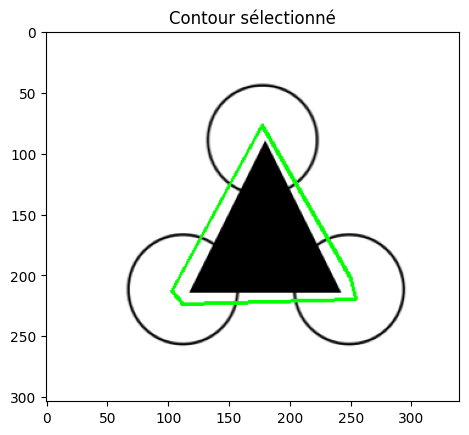

In [3]:
img_path = 'image_chien.png'
contour = []

def select_point(event, x, y, flags, param):
    global contour
    if event == cv2.EVENT_LBUTTONDOWN:
        contour.append((x, y))
        cv2.circle(img_copy, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow("Image", img_copy)

def close_contour(contour):
    if contour[0] != contour[-1]:
        contour.append(contour[0])
    return contour

def get_pixels_from_contour(contour):
    mask = np.zeros_like(img_gray)
    cv2.polylines(mask, [np.array(contour)], isClosed=True, color=255, thickness=1)
    pixels = np.column_stack(np.where(mask == 255))
    return pixels

img = cv2.imread(img_path)

if img is None:
    raise ValueError("L'image n'a pas pu être chargée. Assurez-vous que le chemin est correct.")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_copy = img.copy()

cv2.imshow("Image", img_copy)
cv2.setMouseCallback("Image", select_point)

print("Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

if len(contour) >= 3:
    closed_contour = close_contour(contour)
    pixels = get_pixels_from_contour(closed_contour)

    print("Contour sélectionné :", closed_contour)
    print("Pixels du contour :", pixels)

    img_with_contour = img.copy()
    cv2.polylines(img_with_contour, [np.array(closed_contour)], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    plt.title('Contour sélectionné')
    plt.show()
else:
    print("Sélection incomplète : au moins 3 points sont nécessaires pour un contour.")

### Calcul de la surface cible et source

<Figure size 640x480 with 0 Axes>

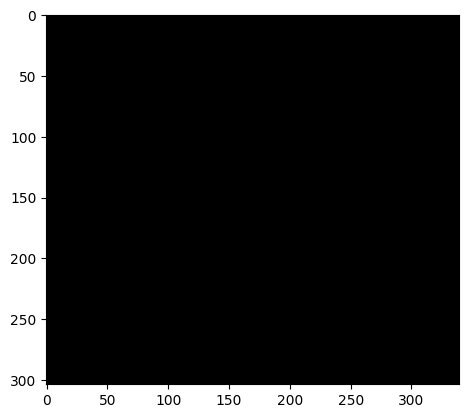

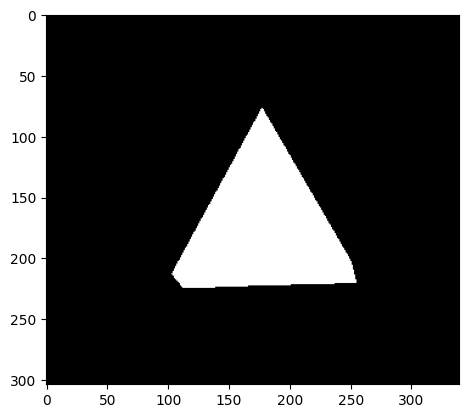

<Figure size 640x480 with 0 Axes>

In [4]:
def find_surface_and_complement(img_shape, contour):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    plt.imshow(mask,cmap="gray")
    cv2.fillPoly(mask, np.array([contour]), 255)
    plt.figure()
    plt.imshow(mask,cmap="gray")
    surface_pixels = np.column_stack(np.where(mask == 255))
    complement_pixels = np.column_stack(np.where(mask == 0))

    return surface_pixels, complement_pixels

pixels_rev=np.array([[pix[1],pix[0]] for pix in pixels])

cible, source = find_surface_and_complement(img.shape,pixels_rev)
img_in_progress = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
filled = np.zeros(img_gray.shape, dtype=bool)
mask = np.zeros_like(img_in_progress)
for pix in source:
    filled[pix[0],pix[1]]=True
    mask[pix[0],pix[1]] = 1
for pix in cible:
    img_in_progress[pix[0],pix[1]] = 0
contour = pixels
data_coeff = {}
plt.figure()

### **1a.** Caclul du front à chaque itération

In [7]:
def calculer_front():
    hauteur, largeur = filled.shape
    contour = []

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for i in range(hauteur):
        for j in range(largeur):
            if filled[i, j] == False:
                for di, dj in directions:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < hauteur and 0 <= nj < largeur:
                        if filled[ni, nj] ==True:
                            contour.append([i,j])
                            break

    return np.array(contour)

### **1b.** Calcul des priorités pour le contour

#### Calcul de la confiance pour un pixel $p$ donné et fonction de mise à jour pour le contour

In [6]:
def init_confidence(source,priority):
    for pix in source:
            priority[pix[0],pix[1]] = 1
    return "Pixel source initialisés à 1"

def maj_confidence_pix(y,x,taille_patch,confidence):
    new_p = 0
    hauteur, largeur = confidence.shape
    tp2 = taille_patch//2
    tpcar = taille_patch**2
    for xprime in range(max(0,x - tp2),min(largeur,x+tp2+1)):
        for yprime in range(max(y - tp2,0),min(y+tp2+1,hauteur)):
            new_p += confidence[yprime,xprime]
    confidence[y,x] = new_p / (tpcar)
    return

def maj_confidence_contour(contour,taille_patch,confidence):
    for pix in contour:
        y,x = pix[0],pix[1]
        maj_confidence_pix(y,x,taille_patch,confidence)
    return "Pixels du contour actualisés"

In [8]:
# Initialisations
taille_patch = 9
confidence = np.zeros(img_gray.shape)
init_confidence(source,confidence)

'Pixel source initialisés à 1'

#### Calcul du data coefficient

In [9]:
def calculer_data(image, pixels):
    image = image.astype(np.int16)
    hauteur, largeur,_ = image.shape
    resultats = {}

    for (y, x) in pixels:
        gradient_x = (np.sum(image[y, min(x+1, largeur-1)]) - np.sum(image[y, max(x-1, 0)]))
        gradient_y = (np.sum(image[min(y+1, hauteur-1), x]) - np.sum(image[max(y-1, 0), x]))

        resultats[(y,x)] = (gradient_x**2 + gradient_y**2)**0.5
        # Ajouter le calcul de la normale (même si cela n'a pas l'air d'influer)
    return resultats

### **2a.** Selection du pixel traité

In [10]:
def get_prior_pixel():
    pix = np.zeros([])
    priomax = float('-inf')
    for pixcand in contour:
        prio_cand = confidence[pixcand[0],pixcand[1]] * data_coeff[(pixcand[0],pixcand[1])]
        if prio_cand >= priomax:
            pix = pixcand
    return pix

### **2b.** Calcul du meilleur patch

In [11]:
def distance(source,x_patch,y_patch,filled,img,mask_cropped):
    tp2 = taille_patch//2
    hauteur,largeur,_ = img.shape
    patch = img[y_patch-tp2:y_patch+tp2+1,x_patch-tp2:x_patch+tp2+1]
    patch = patch.astype(np.int64)
    source = source.astype(np.int64)
    diff = source - patch
    ssd = diff**2
    #for i in range(2*tp2+1):
        #for j in range(2*tp2+1):
            #if not filled[i,j]:
                #ssd[i,j] = 0
    ssd_masked = ssd * mask_cropped
    res = np.sum(ssd_masked)
    return res

In [12]:
def is_in_source(filled_cropped):
    for el in filled_cropped:
        for el2 in el:
            if not el2:
                return False
    return True

In [13]:
def get_best_patch(img,x_patch,y_patch):
    hauteur, largeur,_ = img.shape
    distancemin = float('inf')
    tp2 = taille_patch//2
    x_opt, y_opt = taille_patch, taille_patch
    x_min,x_max = tp2,largeur-tp2
    y_min,y_max = tp2,hauteur-tp2
    filled_cropped_patch = filled[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    mask_cropped = mask[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    for y in range(y_min,y_max):
        for x in range(x_min,x_max):
            source = img[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            filled_cropped = filled[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            if is_in_source(filled_cropped):
                distance_cand = distance(source,x_patch,y_patch,filled_cropped_patch,img,mask_cropped)
                if distance_cand < distancemin:
                    x_opt,y_opt = x,y
                    distancemin = distance_cand
    #print(x_opt,y_opt)
    #print(distancemin)
    return x_opt,y_opt

### **2b.** / **3.** Copie du patch et mise a jour des pixels remplis

In [14]:
def copie(x_source,y_source,x_patch,y_patch,img):
    tp2 = taille_patch//2
    nmb = 0
    for i in range(-tp2,tp2+1):
        for j in range(-tp2,tp2+1):
            if (not filled[y_patch+i,x_patch + j]):
                nmb+=1
                img[y_patch + i,x_patch + j] = img[y_source + i,x_source+j]
                confidence[y_patch + i,x_patch +j]=confidence[y_patch,x_patch]
                np.append(source,[y_patch,x_patch])
                filled[y_patch + i,x_patch + j] = True
                mask[y_patch + i,x_patch + j] = 1
    #print("Nombre de pixels copiés",nmb)
    return nmb

## Algorithme final

In [15]:
with tqdm.tqdm(total=cible.shape[0], desc="Traitement des pixels") as pbar:
    while filled[filled==False].shape[0] !=0:
        #t1 = time.time()
        maj_confidence_contour(contour,taille_patch,confidence)
        #print("Après calcul de confidence =",time.time()-t1)
        #t2 = time.time()
        data_coeff = calculer_data(img,contour)
        #print("Après calcul du data =",time.time()-t2)
        #t3 = time.time()
        pix = get_prior_pixel()
        #print("Après calcul du pixel traité =",time.time()-t3)
      #  t4 = time.time()
        y_patch,x_patch = pix[0],pix[1]
        x_opt, y_opt=get_best_patch(img_in_progress,x_patch,y_patch)
     #   print("Après calcul du meilleur patch =",time.time()-t4)
     #   t5 = time.time()
        nb_pixel_traités = copie(x_opt,y_opt,x_patch,y_patch,img_in_progress)
        pbar.update(nb_pixel_traités)
      #  print("Après copie =",time.time()-t5)
     #   t6 = time.time()
     #   print("nombre de pixels non-traités :",filled[filled==False].shape[0])
        contour=calculer_front()
     #   print("Après calcul du front =",time.time()-t6)

Traitement des pixels: 100%|██████████| 11921/11921 [07:05<00:00, 28.00it/s]


In [16]:
cv2.imwrite('image_res.png',cv2.cvtColor(img_in_progress,cv2.COLOR_Lab2BGR))

True

## Améliorations

In [ ]:
print(distance)